In [8]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


import matplotlib.colors as colors

from scipy.stats import probplot
from scipy.stats import normaltest


from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
from ML_Train.CNN_Classifier import  build_classifier_from_vae, create_vae, create_classifier
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [9]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [10]:
train_featuresDF = pd.read_csv('data/featuresDF_train.csv')
train_stats = pd.read_csv('data/stats_train.csv')
train_vibState = pd.read_csv('data/vibState_train.csv')

valid_featuresDF = pd.read_csv('data/featuresDF_valid.csv')
valid_stats = pd.read_csv('data/stats_valid.csv')
valid_vibState = pd.read_csv('data/vibState_valid.csv')


In [11]:
enc = OrdinalEncoder()
X_train = train_featuresDF.values[:,1:1025].astype(np.float32)
Y_train = enc.fit_transform(train_vibState.values[:,1][...,np.newaxis])

X_valid = valid_featuresDF.values[:,1:1025].astype(np.float32)
Y_valid = enc.transform(valid_vibState.values[:,1][...,np.newaxis])

X_train_healthy = X_train[np.argwhere(Y_train.flatten()==0).flatten(),:]
Y_train_healthy = Y_train[np.argwhere(Y_train.flatten()==0).flatten()]
X_train_unhealthy = X_train[np.argwhere(Y_train.flatten()==1).flatten(),:]
Y_train_unhealthy = Y_train[np.argwhere(Y_train.flatten()==1).flatten()]

X_valid_healthy = X_valid[np.argwhere(Y_valid.flatten()==0).flatten(),:]
Y_valid_healthy = Y_valid[np.argwhere(Y_valid.flatten()==0).flatten()]
X_valid_unhealthy = X_valid[np.argwhere(Y_valid.flatten()==1).flatten(),:]
Y_valid_unhealthy = Y_valid[np.argwhere(Y_valid.flatten()==1).flatten()]

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:-1]
Y_train = XY_train[:,-1]

X_valid = XY_valid[:,:-1]
Y_valid = XY_valid[:,-1]

num_samples = np.array([X_train.shape[0],
          X_valid.shape[0]])

max_samples = np.amax(num_samples)

In [6]:
def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    false_positive = conf_matrix[0,1]
    false_negative = conf_matrix[1,0]
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    xlabel = 'Actual State'
    ylabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate

In [7]:
estimators = [('reduce_dim', PCA(n_components=32)), ('gnb', GaussianNB())]
# estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

pipe = Pipeline(estimators)
pipe.fit(X_train,Y_train)

Y_valid_pred = pipe.predict(X_valid)
conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

Y_train_pred = pipe.predict(X_train)
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)

dump(pipe, 'data/pca_gnb.joblib') 

[[266 434]
 [ 75 625]]
0.6364285714285715
[[629  71]
 [ 11 689]]
0.9414285714285714


['data/pca_gnb.joblib']

No handles with labels found to put in legend.


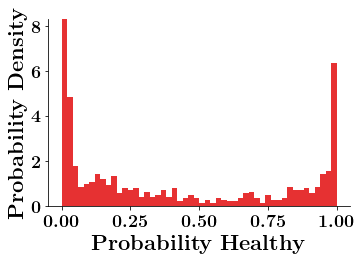

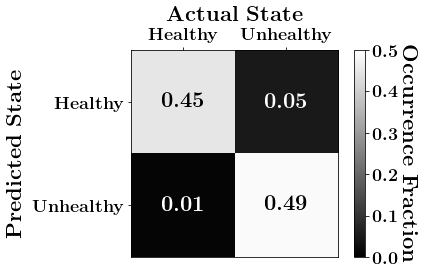

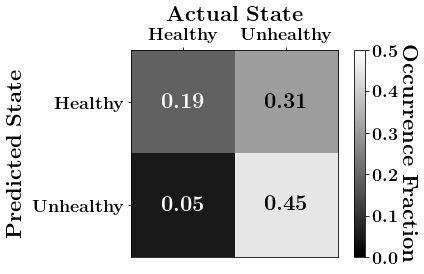

No handles with labels found to put in legend.


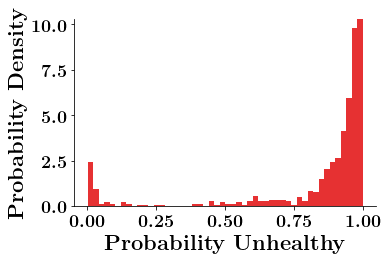

(0.9428341384863124, 0.9782608695652174, 0.9074074074074073)
(0.6918859649122807, 0.7916666666666667, 0.5921052631578947)


In [9]:
pipe.predict_proba(X_train_healthy)[:,0]

responses= np.vstack((
                       pipe.predict_proba(X_valid_healthy)[:,0]))
genplt.plot_histogram(responses,[''],
               'Probability Healthy',
               'Probability Density',
               'pca_gnb_predict_healthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_valid'
                       )

responses= np.vstack((
                       pipe.predict_proba(X_valid_unhealthy)[:,1]))
genplt.plot_histogram(responses,[''],
               'Probability Unhealthy',
               'Probability Density',
               'pca_gnb_predict_unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [10]:
def normalize_scores(scores,log_prob=False):
    
    if log_prob:
        scores = np.log(np.abs(scores - 1.1 * np.amax(scores)))
    
    norm_mean = np.mean(scores[:,0])
    norm_std = np.std(scores[:,0])
    
    scores = (scores - norm_mean) / norm_std
    
    [print(normaltest(scores[:,i])) for i in range(scores.shape[1])]
    [print(np.std(scores[:,i]), np.mean(scores[:,i])) for i in range(scores.shape[1])]
    
    return scores

In [11]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape,
                   dense_nodes,
                   classes,
                   ):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for i in range(len(filters)):
        x = Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i])(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(len(dense_nodes)):
        x = Dense(dense_nodes[i],activation='relu')(x)
        
    x = Dense(classes,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    return cnn_classifier

def create_classifier(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
    dense_nodes = param_dict["dense_nodes"]
    classes = param_dict["classes"]
    
    classifier = build_classifier(filters,kernels,strides,dilation_rates,input_shape,dense_nodes,classes)
 
    return classifier
        

In [18]:
train = True
if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/CNN-MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/CNN-MLP.h5')
    print(model.summary())
else:

    filters=[8,8,8]
    kernels = [3,3,3]
    strides=[1,1,1,1,1]
    dilation_rates=[1,1,1,1,1]
    input_shape = [1024,1]
    dense_nodes = [512,64]
    codings_size = 2

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
        "dense_nodes":dense_nodes,
        "classes":2
    }
    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2
    model = create_classifier(param_dict)
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
                validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                epochs=10,
                batch_size=8,
                verbose=1)
    
    print(model.summary())
    
    model.save('../../Models/MLP-Classifier/Full/CNN-MLP.h5',save_format='tf')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(os.path.join('../../Models/MLP-Classifier/Lite', 'CNN-MLP.tflite',),
     "wb").write(tflite_model)

Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - 2s 1ms/sample - loss: 0.6760 - accuracy: 0.6943 - val_loss: 1.2477 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - 1s 676us/sample - loss: 0.3869 - accuracy: 0.8329 - val_loss: 1.6836 - val_accuracy: 0.5000
Epoch 3/10
1400/1400 [==============================] - 1s 657us/sample - loss: 0.2253 - accuracy: 0.9171 - val_loss: 1.1341 - val_accuracy: 0.5179
Epoch 4/10
1400/1400 [==============================] - 1s 659us/sample - loss: 0.1434 - accuracy: 0.9514 - val_loss: 0.7650 - val_accuracy: 0.7343
Epoch 5/10
1400/1400 [==============================] - 1s 663us/sample - loss: 0.1179 - accuracy: 0.9650 - val_loss: 0.5213 - val_accuracy: 0.8086
Epoch 6/10
1400/1400 [==============================] - 1s 651us/sample - loss: 0.1036 - accuracy: 0.9664 - val_loss: 0.6091 - val_accuracy: 0.8236
Epoch 7/10
1400/1400 [==============================] - 1s 637us/s

In [14]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[474 226]
 [  0 700]]
0.8385714285714285
[[694   6]
 [  0 700]]
0.9957142857142857


In [15]:
model.predict(X_valid_unhealthy[...,np.newaxis])

array([[0.00303337, 0.99696666],
       [0.00322676, 0.9967732 ],
       [0.0035402 , 0.9964598 ],
       ...,
       [0.01411347, 0.9858866 ],
       [0.01569096, 0.984309  ],
       [0.012702  , 0.987298  ]], dtype=float32)

No handles with labels found to put in legend.


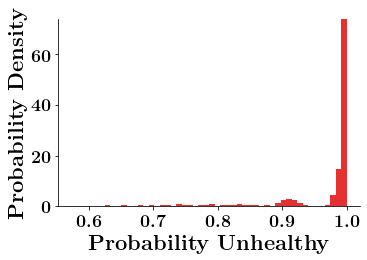

No handles with labels found to put in legend.


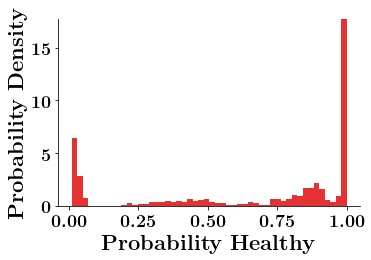

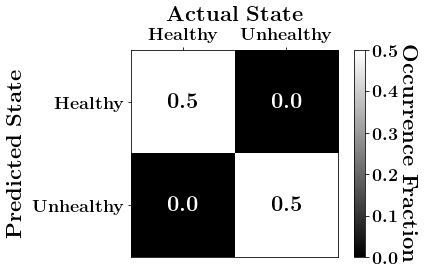

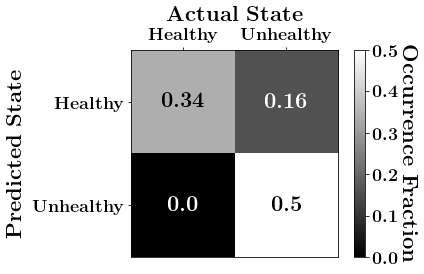

(1.0, 1.0, 1.0)
(0.8787878787878788, 1.0, 0.7575757575757576)


In [16]:
genplt.plot_histogram(model.predict(X_valid_unhealthy[...,np.newaxis])[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'cnn_mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy[...,np.newaxis])[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'cnn_mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_cnn_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_cnn_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [22]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_mlp_classifier(
                   hidden_nodes,
                   input_shape,
                   classes,
                   ):
    
    mlp = Sequential()
    mlp.add(Input(shape=input_shape))
    mlp.add(Flatten())
    
    for i in range(len(hidden_nodes)):
        if i == 0:
            mlp.add(Dense(hidden_nodes[i], 
                              activation='selu'))
        else:
            mlp.add(Dense(hidden_nodes[i], activation='selu'))
            
    mlp.add(Dense(classes,activation='softmax'))
        
    return mlp

In [23]:

if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/MLP.h5')
    print(model.summary())
else:
    input_shape = [1024]
    dense_nodes = [512,128,64]

    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2

    model = create_mlp_classifier(dense_nodes,input_shape,num_classes)


    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
                validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                epochs=20,
                batch_size=8,
                verbose=1)

    model.save('../../Models/MLP-Classifier/Full/MLP.h5',save_format='tf')


    
Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

Train on 1400 samples, validate on 1400 samples
Epoch 1/20
1400/1400 [==============================] - 1s 494us/sample - loss: 0.8480 - accuracy: 0.5207 - val_loss: 0.8258 - val_accuracy: 0.5000
Epoch 2/20
1400/1400 [==============================] - 0s 334us/sample - loss: 0.7162 - accuracy: 0.5621 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 3/20
1400/1400 [==============================] - 0s 337us/sample - loss: 0.6495 - accuracy: 0.6400 - val_loss: 0.7341 - val_accuracy: 0.5779
Epoch 4/20
1400/1400 [==============================] - 0s 336us/sample - loss: 0.4959 - accuracy: 0.7693 - val_loss: 1.2066 - val_accuracy: 0.5264
Epoch 5/20
1400/1400 [==============================] - 0s 327us/sample - loss: 0.3363 - accuracy: 0.8600 - val_loss: 1.8928 - val_accuracy: 0.5357
Epoch 6/20
1400/1400 [==============================] - 0s 331us/sample - loss: 0.3892 - accuracy: 0.8329 - val_loss: 1.1072 - val_accuracy: 0.5936
Epoch 7/20
1400/1400 [==============================] - 0s 336us

In [24]:
model.predict(X_valid)

array([[2.3719278e-06, 9.9999762e-01],
       [9.7940814e-01, 2.0591874e-02],
       [4.7526433e-04, 9.9952471e-01],
       ...,
       [3.0014534e-03, 9.9699855e-01],
       [3.7176656e-03, 9.9628240e-01],
       [4.9224900e-06, 9.9999511e-01]], dtype=float32)

No handles with labels found to put in legend.


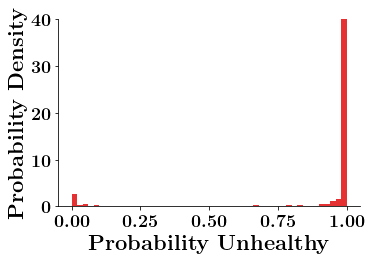

No handles with labels found to put in legend.


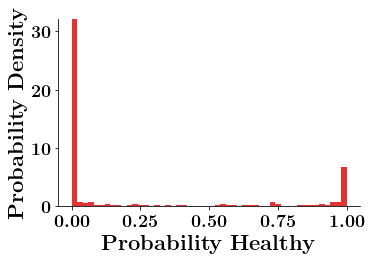

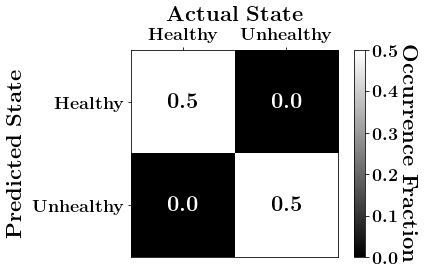

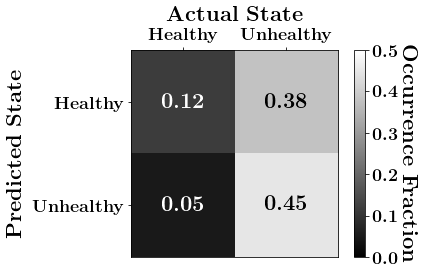

(1.0, 1.0, 1.0)
(0.6240255138199858, 0.7058823529411765, 0.5421686746987951)


In [25]:
genplt.plot_histogram(model.predict(X_valid_unhealthy)[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy)[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_mlp_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_mlp_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [26]:

conf_matrix_mlp_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_mlp_valid = np.sum(np.diagonal(conf_matrix_mlp_valid)) / np.sum(conf_matrix_mlp_valid)
print(conf_matrix_mlp_valid)
print(accuracy_mlp_valid)

conf_matrix_mlp_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_mlp_train = np.sum(np.diagonal(conf_matrix_mlp_train)) / np.sum(conf_matrix_mlp_train)
print(conf_matrix_mlp_train)
print(accuracy_mlp_train)

[[174 526]
 [ 69 631]]
0.575
[[693   7]
 [  1 699]]
0.9942857142857143


In [27]:

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='../../Models/MLP-Classifier/Lite/CNN-MLP.tflite')

def tflite_inference(data,tflite_interpreter):
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = data[:,np.newaxis,:,np.newaxis].astype(np.float32)

    output_shape = output_details[0]['shape']
    num_samples = input_data.shape[0]
    all_outputs = np.zeros((num_samples,output_shape[1]))

    for i in range(num_samples):

        interpreter.set_tensor(input_details[0]['index'], input_data[i,...])
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index']).flatten()

        all_outputs[i,:] = output_data
        
    return all_outputs



In [247]:
Y_cnn_lite_train_pred = tflite_inference(X_train,interpreter)
Y_cnn_lite_valid_pred = tflite_inference(X_valid,interpreter)

Y_cnn_lite_train_pred = np.argmax(Y_cnn_lite_train_pred,axis=1)
Y_cnn_lite_valid_pred = np.argmax(Y_cnn_lite_valid_pred,axis=1)

In [248]:
conf_matrix_cnn_lite_valid = confusion_matrix(Y_valid, Y_cnn_lite_valid_pred)
accuracy_cnn_lite_valid = np.sum(np.diagonal(conf_matrix_cnn_lite_valid)) / np.sum(conf_matrix_cnn_lite_valid)
print(conf_matrix_cnn_lite_valid)
print(accuracy_cnn_lite_valid)

conf_matrix_cnn_lite_train = confusion_matrix(Y_train, Y_cnn_lite_train_pred)
accuracy_cnn_lite_train = np.sum(np.diagonal(conf_matrix_cnn_lite_train)) / np.sum(conf_matrix_cnn_lite_train)
print(conf_matrix_cnn_lite_train)
print(accuracy_cnn_lite_train)

[[419 281]
 [ 13 687]]
0.79
[[700   0]
 [  0 700]]
1.0


No handles with labels found to put in legend.


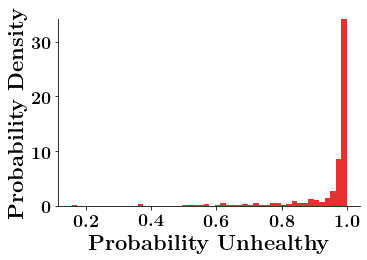

No handles with labels found to put in legend.


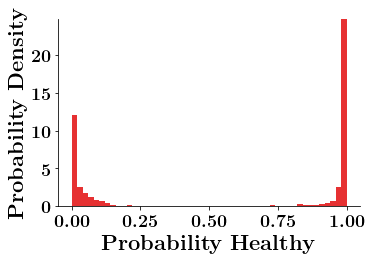

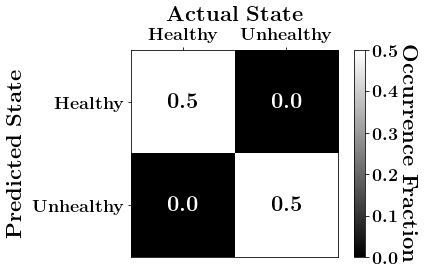

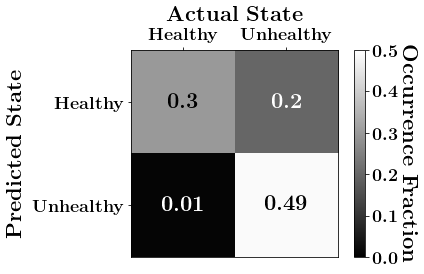

(1.0, 1.0, 1.0)
(0.8389434315100515, 0.9677419354838709, 0.7101449275362319)


In [249]:
genplt.plot_histogram(tflite_inference(X_valid_unhealthy,interpreter)[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'cnn_lite_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(tflite_inference(X_valid_healthy,interpreter)[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'cnn_lite_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_cnn_lite_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_lite_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_cnn_lite_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'cnn_lite_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)